<a href="https://colab.research.google.com/github/Cjeyms/CCMACLRL_EXERCISES_COM222ML/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [1]:
import pandas as pd
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [3]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Validation Set**

Use this set to evaluate your model

In [4]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [5]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [6]:
# put your answer here
data = df_train.head(10)
print(data)

                                                text  label
0  Presidential candidate Mar Roxas implies that ...      1
1  Parang may mali na sumunod ang patalastas ng N...      1
2                    Bet ko. Pula Ang Kulay Ng Posas      1
3                               [USERNAME] kakampink      0
4  Bakit parang tahimik ang mga PINK about Doc Wi...      1
5  "Ang sinungaling sa umpisa ay sinungaling hang...      1
6                                          Leni Kiko      0
7  Nahiya si Binay sa Makati kaya dito na lang sa...      1
8                            Another reminderHalalan      0
9  [USERNAME] Maybe because VP Leni Sen Kiko and ...      0


2. Check how many rows and columns are in the training dataset using `.info()`

In [7]:
# put your answer here
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [8]:
# put your answer here
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [9]:
# put your answer here
df_train.duplicated().sum()

0

5. Check how many rows belong to each class

In [10]:
# put your answer here
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [11]:
# put your answer here
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

7. Remove rows with NaN values

In [12]:
# put your answer here
df_train.dropna(inplace=True)
df_train.isnull().sum()

,0
text,0
label,0


8. Convert all text to lowercase

In [13]:
# put your answer here
df_train['text'] = df_train['text'].str.lower()
df_train.head()

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko. pula ang kulay ng posas,1
3,[username] kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1


9. Remove digits, URLS and special characters

In [14]:
# put your answer here
df_train['text'] = (df_train['text']
                    .str.replace(r'\n', '', regex=True)
                    .str.replace(r'\d+', '', regex=True)
                    .str.replace(r'https?:\/\/.*[\r\n]*', '', regex=True)
                    .str.replace(r'[^\x00-\x7f]', ' ', regex=True)
                    .str.replace(r'[^\w\s]', '', regex=True))

In [30]:
df_train.head(10)

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali sumunod patalastas nescaf coff...,1
2,bet ko pula kulay posas,1
3,username kakampink,0
4,parang tahimik pink about doc willie ong no re...,1
5,sinungaling umpisa ay sinungaling hanggang dul...,1
6,leni kiko,0
7,nahiya si binay makati lang mandaluyong bwiset...,1
8,another reminderhalalan,0
9,username maybe because vp leni sen kiko and th...,0


10. Remove stop words

In [15]:
# put your answer here
# Extended list of Tagalog stop words
tagalog_stop_words = [
    "ako", "ako'y", "alam", "at", "dahil", "habang", "ito", "iyan",
    "iyon", "ka", "kailangan", "kasama", "mga", "mas", "na", "ng",
    "ngunit", "o", "sa", "saan", "sino", "tayo", "tungkol", "upang", "wala",
    "ang", "anong", "bawat", "bago", "bakit", "dati", "dito", "ganito",
    "ganoon", "hindi", "iba", "ilalim", "isinasaalang-alang", "iyong",
    "kahit", "kaya", "kung", "maging", "muli", "narito", "ngayon",
    "pagkatapos", "paano", "pati", "tulad", "yung"
]
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tagalog_stop_words)]))
df_train.head()

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali sumunod patalastas nescaf coff...,1
2,bet ko pula kulay posas,1
3,username kakampink,0
4,parang tahimik pink about doc willie ong no re...,1


11. Use Stemming or Lemmatization

In [16]:
# put your answer here
lemmatizer = WordNetLemmatizer()
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df_train.head()

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali sumunod patalastas nescaf coff...,1
2,bet ko pula kulay posas,1
3,username kakampink,0
4,parang tahimik pink about doc willie ong no re...,1


## C. Training your model

12. Put all text training data in variable **X_train**

In [17]:
# put your answer here
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [18]:
# put your answer here
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [19]:
# put your answer here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

15. Create an instance of MultinomalNB()

In [20]:
# put your answer here
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=0.1)

16. Train the model using `.fit()`

In [21]:
# put your answer here
model.fit(X_train_transformed, y_train)

MultinomialNB(alpha=0.1)

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [22]:
# put your answer here
X_validation = df_validation['text']
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [23]:
# put your answer here
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_validation = df_validation['label']

accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)

print(f"Accuracy (Validation): {accuracy}")
print(f"Precision (Validation): {precision}")
print(f"Recall (Validation): {recall}")
print(f"F1 Score (Validation): {f1}")

Accuracy (Validation): 0.8196428571428571
Precision (Validation): 0.788339670468948
Recall (Validation): 0.8791519434628975
F1 Score (Validation): 0.8312729702639492


19. Create a confusion matrix using the **validation dataset**

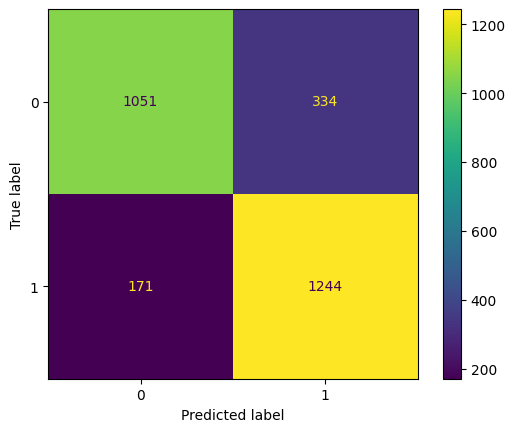

In [24]:
# put your answer here
cm = confusion_matrix(y_validation, y_validation_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [25]:
# put your answer here
X_test = df_test['text']
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [26]:
# put your answer here

y_test = df_test['label']
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"Accuracy (Test): {accuracy_test}")
print(f"Precision (Test): {precision_test}")
print(f"Recall (Test): {recall_test}")
print(f"F1 Score (Test): {f1_test}")

Accuracy (Test): 0.8103202846975089
Precision (Test): 0.7802981205443941
Recall (Test): 0.8612303290414879
F1 Score (Test): 0.8187691261475688


22. Create a confusion matrix using the **test dataset**

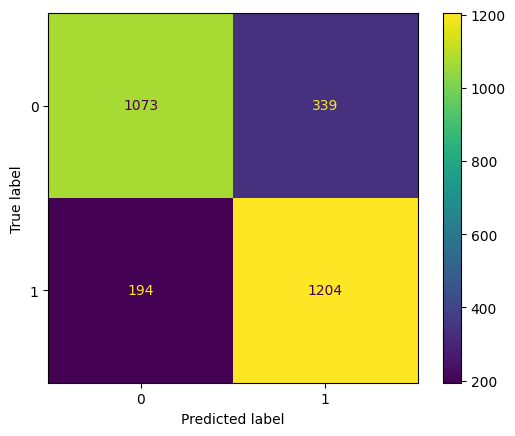

In [27]:
# put your answer here
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [28]:
new_input = ["Bayang Magiliw, Perlas ng Silanganan Alab ng Puso sa dibdib mo'y buhay."]
new_input_transformed = vectorizer.transform(new_input)
prediction = model.predict(new_input_transformed)
print("Prediction:", prediction)

Prediction: [0]


24. Test the model by providing a hate speech input. The model should predict it as 1

In [29]:
new_input = ["Ang init ng ulo ko ang gulo ng paligid ang sarap talaga sumigaw ng putang ina!"]
new_input_transformed = vectorizer.transform(new_input)
prediction = model.predict(new_input_transformed)
print("Prediction:", prediction)

Prediction: [1]
